# Introduction to Boosting
References: 
- https://github.com/dmlc/xgboost/tree/master/demo/guide-python
- https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- http://xgboost.readthedocs.org/en/latest/parameter.html#general-parameters
- https://github.com/dmlc/xgboost/tree/master/demo/guide-python
- https://xgboost.readthedocs.io/en/latest/python/python_api.html

The term `Boosting` refers to a family of algorithms which converts weak learner to strong learners.

There are many boosting algorithms which impart additional boost to model’s accuracy. In this tutorial, we’ll learn about the two most commonly used algorithms i.e. Gradient Boosting (GBM) and XGboost.

Generally XGboost is considered more advanced than gbm. 
- xgboost supports regularization, however gbm does not.
- xgboost is blazingley faster than gbm.
- xgboost has built-in routine to handle missing values.
- xgboost has tree pruning mechanisms,however gbm and random forest are greedy algorithms and do not have tree pruning.
- In xgboost we can run cross-validation at each iteration of the boosting. But in gbm, we have to run grid search.

# Imports

In [0]:
import numpy as np
import pandas as pd

random_state = 100

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams.update({'font.size': 16})

plt.style.use('ggplot')
%matplotlib inline

In [0]:
import xgboost as xgb

In [0]:
# six and pickle
import six
import pickle
import joblib

In [0]:
# scale and split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [0]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
# sklearn scalar metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [0]:
# roc auc and curves
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [0]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Useful Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

# Load the data

In [64]:
ifile = 'https://github.com/bhishanpdl/Project_Fraud_Detection/blob/master/data/raw/creditcard.csv.zip?raw=true'
df = pd.read_csv(ifile,compression='zip')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Balance the dataset for undersampling

In [65]:
target = 'Class'
df[target].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [66]:
# shuffle data
df = df.sample(frac=1)

df_low = df.loc[df[target] == 1]
df_high = df.loc[df[target] == 0][:df_low.shape[0]]

df_balanced = pd.concat([df_low, df_high])
df_balanced = df_balanced.sample(frac=1, random_state=random_state)

df_balanced[target].value_counts()

1    492
0    492
Name: Class, dtype: int64

# Train test split with stratify

In [67]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    df.drop(target,axis=1), df[target],
    test_size=0.2, random_state=random_state, stratify=df[target])

df.shape, Xtrain.shape, Xtest.shape

((284807, 31), (227845, 30), (56962, 30))

In [68]:
df.columns.drop('Class')

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [69]:
df_Xtrain = pd.DataFrame(Xtrain, columns=df.columns.drop(target))
df_Xtest = pd.DataFrame(Xtest, columns=df.columns.drop(target))

print(df_Xtrain.shape)
df_Xtrain.head()

(227845, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
75721,56220.0,-1.776883,0.926679,0.764349,0.102876,-0.501826,-0.109312,0.254832,0.664410,-0.298386,-0.339734,0.367468,0.809640,-0.253872,0.366098,-1.060441,0.078077,-0.103579,0.134028,0.833793,-0.243735,-0.162365,-0.214302,0.081719,0.041698,0.048768,0.208978,-0.245448,-0.268644,80.80
131873,79767.0,-0.692028,-0.752283,2.651769,-1.374700,-1.440949,0.838129,-0.631453,0.548979,-0.053689,-0.335657,0.337906,0.777179,-0.395664,-1.015378,-2.470207,-1.637787,0.325068,1.010333,-1.283494,-0.447497,-0.198948,0.087203,0.188247,0.256745,-0.714269,0.845904,0.119715,0.144500,81.00
188400,127955.0,-0.845273,1.529549,-1.046374,0.851842,2.262508,-0.434918,1.391544,-0.522618,-0.168068,0.288615,-1.035420,-0.399592,0.380711,-1.582082,-0.030669,-0.651198,0.904275,0.394473,0.815993,0.168306,-0.102261,0.289524,-0.523971,-0.057898,0.130907,-0.424041,0.042949,0.164450,6.19
212698,138962.0,-0.404266,-0.523200,2.240300,-2.588043,-0.905321,0.197854,-0.597900,-0.091589,-1.802952,1.039242,-1.109905,-1.735575,0.263834,-0.925715,1.025711,-0.021478,0.056344,0.744570,0.059804,-0.135481,-0.158954,-0.038956,-0.254142,0.531142,0.130260,-0.138596,-0.210187,-0.133936,18.69
169666,119801.0,2.039116,0.548359,-2.380305,0.775443,0.519606,-1.738515,0.331491,-0.360443,0.574173,-1.194591,0.171159,-0.448408,-0.471467,-2.439747,1.166634,0.733543,1.851638,1.236182,-0.767286,-0.188702,0.098215,0.472202,-0.035461,-0.239882,0.227829,-0.096011,0.020377,0.006324,1.00


# Modelling xgboost

In [70]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

clf_xgb = XGBClassifier(max_depth=5, 
                        learning_rate=0.01, 
                        n_estimators=100, 
                        gamma=0, 
                        min_child_weight=1, 
                        subsample=0.8, 
                        colsample_bytree=0.8, 
                        reg_alpha=0.005)

clf_xgb.fit(Xtrain, ytrain)
ypreds = clf_xgb.predict(Xtest)

acc = (ypreds == ytest).sum().astype(float) / len(ypreds)*100

print(acc)

99.96313331694815


In [71]:
%%time
clf_xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(clf_xgb_cv, Xtrain, ytrain, cv=2, scoring = "accuracy")
print("Train Scores:", scores)
print("Train Mean:", scores.mean())
print("Train Standard Deviation:", scores.std())

Scores: [0.99949966 0.99945577]
Mean: 0.9994777150170202
Standard Deviation: 2.194703541874565e-05
CPU times: user 52.3 s, sys: 24.9 ms, total: 52.3 s
Wall time: 52.4 s


# Model Evaluation

In [72]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

ypreds_cv2 = cross_val_predict(clf_xgb, Xtest, ytest, cv=2)
confusion_matrix(ytest, ypreds_cv2)

array([[56855,     9],
       [   28,    70]])

In [73]:
from sklearn.metrics import precision_score, recall_score


print("XGboost Accuracy: " % (scores.mean()))
print("XGboost Precision:", precision_score(ytest, ypreds_cv2, average='micro'))
print("XGboost Recall:",recall_score(ytest, ypreds_cv2, average='micro'))
print("XGboost F1-Score:", f1_score(ytest, ypreds_cv2, average='micro'))

Precision: 0.9993504441557529
Recall: 0.9993504441557529


# Feature Importances

In [74]:
df_imp = pd.DataFrame({
    'Feature': df.columns.difference(['Class']).values,
    'Importance': clf_xgb.feature_importances_
})


df_imp = df_imp.sort_values(by='Importance',ascending=False)
df_imp.head()

,Feature,Importance
17,V23,0.465874
12,V19,0.083818
14,V20,0.056624
10,V17,0.045376
7,V14,0.032432


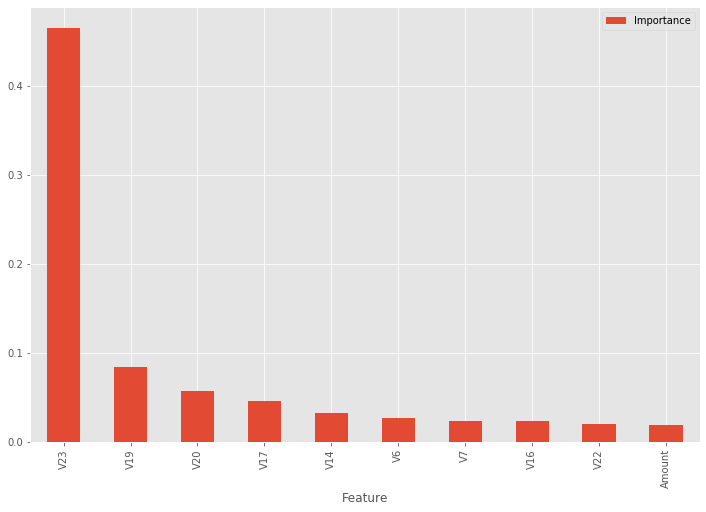

In [75]:
df_imp.head(10).set_index('Feature').plot.bar(figsize=(12,8))

# Comparison with other classifiers

## Random Forest

In [76]:
%%time
clf_rfc = RandomForestClassifier(n_estimators=100,
                                random_state=random_state,
                                n_jobs=-1)
clf_rfc.fit(Xtrain, ytrain)


ypreds_rfc = clf_rfc.predict(Xtest)
acc_rfc = (ypreds_rfc == ytest).sum().astype(float) / len(ypreds_rfc)*100

print("Random Forest Accuracy: " % (acc_rfc))
print("Random Forest Precision:", precision_score(ytest, ypreds_rfc, average='micro'))
print("Random Forest Recall:",recall_score(ytest, ypreds_rfc, average='micro'))
print("Random Forest F1-Score:", f1_score(ytest, ypreds_rfc, average='micro'))

 Random Forest Accuracy: 99.96
Random Forest Precision: 0.9995962220427653
Random Forest Recall: 0.9995962220427653
Random Forest F1-Score: 0.9995962220427653
CPU times: user 5min 5s, sys: 154 ms, total: 5min 6s
Wall time: 2min 34s


## Naive Bayes Classifier
Naive Bayes assumes normality of dataset. We can use MaxAbsScaler to gnb.

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.naive_bayes import GaussianNB

clf_gnb = Pipeline([
    ("scale", MaxAbsScaler()),
    ("model", GaussianNB())
])


clf_gnb.fit(Xtrain, ytrain)

ypreds_gnb = clf_gnb.predict(Xtest)
acc_gnb = (ypreds_gnb == ytest).sum().astype(float) / len(ypreds_gnb)*100

print("Gaussian NB Accuracy: %3.2f" % (acc_gnb))
print("Gaussian NB Precision:", precision_score(ytest, ypreds_gnb, average='micro'))
print("Gaussian NB Recall:",recall_score(ytest, ypreds_gnb, average='micro'))
print("Gaussian NB F1-Score:", f1_score(ytest, ypreds_gnb, average='micro'))

 Gaussian NB Accuracy: 97.82
Gaussian NB Precision: 0.9782311014360451
Gaussian NB Recall: 0.9782311014360451
Gaussian NB F1-Score: 0.9782311014360451


# Xgboost Parameter Tuning
References:
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?
- http://xgboost.readthedocs.org/en/latest/parameter.html#general-parameters
- https://github.com/dmlc/xgboost/tree/master/demo/guide-python
- https://xgboost.readthedocs.io/en/latest/python/python_api.html

## Most Common Parameters

- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- n_estimators: number of trees you want to build.
- objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.
- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- alpha: L1 regularization on leaf weights. A large value leads to more regularization.
- lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

The overall parameters have been divided into 3 categories by XGBoost authors:

- General Parameters: Guide the overall functioning
- Booster Parameters: Guide the individual booster (tree/regression) at each step
- Learning Task Parameters: Guide the optimization performed

## General Parameters
These define the overall functionality of XGBoost.

1. booster [default=gbtree]
Select the type of model to run at each iteration. It has 2 options:
gbtree: tree-based models
gblinear: linear models
2. silent [default=0]:
Silent mode is activated is set to 1, i.e. no running messages will be printed.
It’s generally good to keep it 0 as the messages might help in understanding the model.
3. nthread [default to maximum number of threads available if not set]
This is used for parallel processing and number of cores in the system should be entered
If you wish to run on all cores, value should not be entered and algorithm will detect automatically
There are 2 more parameters which are set automatically by XGBoost and you need not worry about them. Lets move on to Booster parameters.

## Booster Parameters
Though there are 2 types of boosters, I’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

1. eta [default=0.3]
Analogous to learning rate in GBM
Makes the model more robust by shrinking the weights on each step
Typical final values to be used: 0.01-0.2
2. min_child_weight [default=1]
Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.
3. max_depth [default=6]
The maximum depth of a tree, same as GBM.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
Typical values: 3-10
4. max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, GBM will ignore max_depth.
5. gamma [default=0]
A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
6. max_delta_step [default=0]
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
This is generally not used but you can explore further if you wish.
7. subsample [default=1]
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1
8. colsample_bytree [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
Typical values: 0.5-1
9. colsample_bylevel [default=1]
Denotes the subsample ratio of columns for each split, in each level.
I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.
10. lambda [default=1]
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
11. alpha [default=0]
L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
12. scale_pos_weight [default=1]
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.


# Learning Task Parameters
These parameters are used to define the optimization objective the metric to be calculated at each step.

1. objective [default=reg:linear]
This defines the loss function to be minimized. Mostly used values are:
- binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
- multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
- multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
2. eval_metric [ default according to objective ]
The metric to be used for validation data.
The default values are rmse for regression and error for classification.
Typical values are:
```
rmse – root mean square error
mae – mean absolute error
logloss – negative log-likelihood
error – Binary classification error rate (0.5 threshold)
merror – Multiclass classification error rate
mlogloss – Multiclass logloss
auc: Area under the curve
```
3. seed [default=0]
The random number seed.
Can be used for generating reproducible results and also for parameter tuning.


If you’ve been using Scikit-Learn till now, these parameter names might not look familiar. A good news is that xgboost module in python has an sklearn wrapper called XGBClassifier. It uses sklearn style naming convention. The parameters names which will change are:

- eta –> learning_rate
- lambda –> reg_lambda
- alpha –> reg_alpha



## General Approach for Parameter Tuning
The various steps to be performed are:

1. Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
2. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
3. Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
4. Lower the learning rate and decide the optimal parameters .


Let us look at a more detailed step by step approach.

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

1. max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
2. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
3. gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
4. subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
5. scale_pos_weight = 1: Because of high class imbalance.

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

In [0]:
def modelling_xgboost(model, df_Xtrain, df_Xtest, predictors, ytrain,
                      ytest, useTrainCV=True,cv_folds=5,
                      early_stopping_rounds=50):
    import xgboost as xgb
    from sklearn import metrics

    Xtrain = df_Xtrain[predictors].to_numpy()
    Xtest  = df_Xest[predictors].to_numpy()
    if useTrainCV:
        params_xgb = model.get_xgb_params()
        train_xgb = xgb.DMatrix(Xtrain, label=ytrain)

        cvresult = xgb.cv(params_xgb, train_xgb,
                          num_boost_round=model.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='auc',
                          early_stopping_rounds=early_stopping_rounds,
                          seed=random_state)

        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the modelorithm on the data
    model.fit(Xtrain, ytrain,eval_metric='auc')
        
    #Predict training set:
    ypreds_test = model.predict(Xtest)
    ypreds_probs_test = model.predict_proba(Xtest)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Test Accuracy : %.4g" % metrics.accuracy_score(ytrain, ypreds_train))
    print("Test AUC: %f" % metrics.roc_auc_score(ytrain, ypreds_probs_train))
                    
    ser_feat_imp = pd.Series(model.feature_importances_, index=predictors)
    ser_feat_imp = ser_feat_imp.sort_values(ascending=False)
    ser_feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return model

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Model Report
Accuracy : 0.9998
AUC Score (Train): 0.999645
CPU times: user 11min 50s, sys: 1.53 s, total: 11min 52s
Wall time: 6min 5s


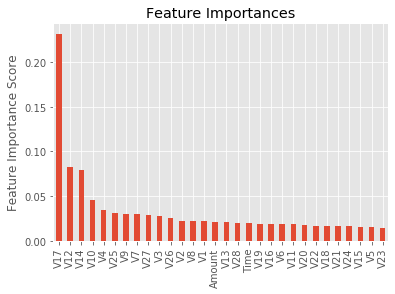

In [79]:
%%time
predictors = [x for x in df.columns if x not in ['Class']]

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=random_state
    )

model1 = modelling_xgboost(xgb1, df_Xtrain, df_Xtest, predictors, ytrain, ytest)

In [81]:
show_method_attributes(model1)

,0,1,2,3,4,5,6
0,apply,colsample_bytree,get_num_boosting_rounds,learning_rate,n_classes_,predict_proba,score
1,base_score,evals_result,get_params,load_model,n_estimators,random_state,seed
2,booster,feature_importances_,get_xgb_params,max_delta_step,n_jobs,reg_alpha,set_params
3,classes_,fit,importance_type,max_depth,nthread,reg_lambda,silent
4,coef_,gamma,intercept_,min_child_weight,objective,save_model,subsample
5,colsample_bylevel,get_booster,kwargs,missing,predict,scale_pos_weight,verbosity
6,colsample_bynode,,,,,,


In [103]:
n_estimators_best = model1.n_estimators # use this for later tuning
n_estimators_best

88

### Xgboost Model Visualization

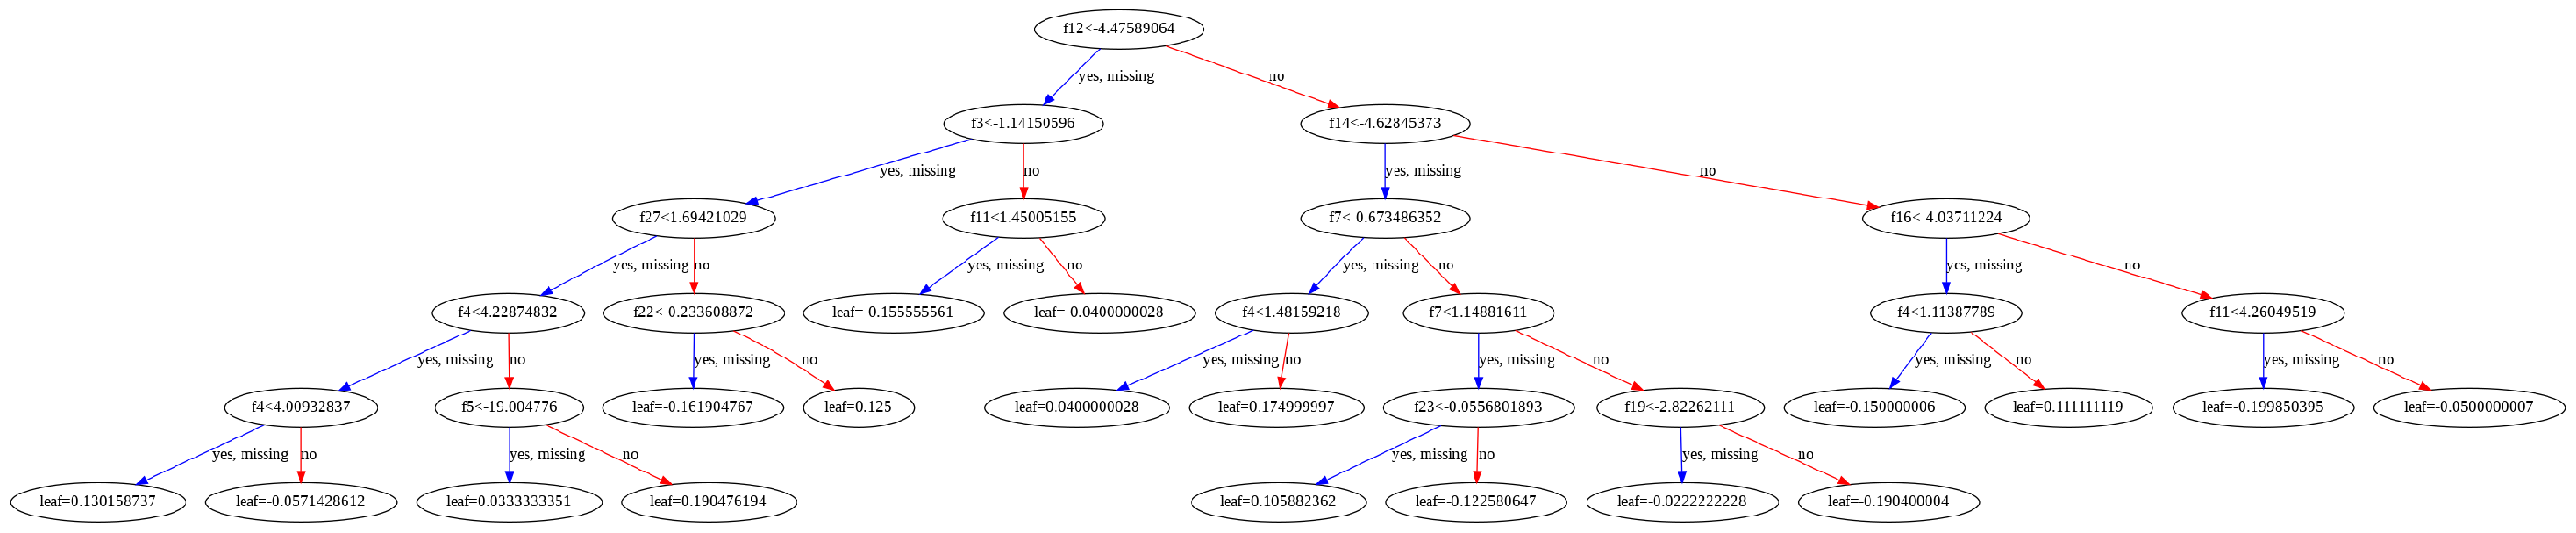

In [88]:
fig, ax = plt.subplots(1,1, figsize=(50,50))
xgb.plot_tree(model1, ax =ax)

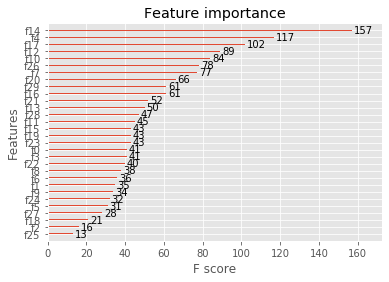

In [83]:
xgb.plot_importance(model1)

In [90]:
show_method_attributes(xgb.plotting)

,0,1,2,3,4,5,6
0,Booster,XGBModel,absolute_import,plot_importance,plot_tree,re,to_graphviz
1,BytesIO,,,,,,


## Step 2: Tune max_depth and min_child_weight
We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

Important Note: I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

In [0]:
%%timeit

from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=n_estimators_best,
                                                  max_depth=5,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=40, 
                                                  scale_pos_weight=1,
                                                  seed=random_state), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False, 
                        cv=5)

gsearch1.fit(df_Xtrain[predictors],ytrain)
# this takes long time comment this after fitting.



In [98]:
show_method_attributes(gsearch1)

,0,1,2,3,4,5,6
0,classes_,estimator,inverse_transform,param_grid,predict_log_proba,return_train_score,set_params
1,cv,fit,multimetric_,pre_dispatch,predict_proba,score,transform
2,decision_function,get_params,n_jobs,predict,refit,scoring,verbose
3,error_score,iid,,,,,


In [102]:
gsearch1.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_di

Here, we get the optimum values as:

``` 
max_depth = 
min_child_weight =  ( if it is maximum, we need to tune more)

acc before tuning:
acc after tuning:

Note: once accuracy is hight, even small increase becomes exponentially difficult.
```

In [0]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}

gsearch2b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                   n_estimators=n_estimators_best,
                                                   max_depth=max_depth_best,
                                                   min_child_weight=2, # we tune it
                                                   gamma=0,
                                                   subsample=0.8,
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic',
                                                   nthread=4,
                                                   scale_pos_weight=1,
                                                   seed=random_state), 
                         param_grid = param_test2b,
                         scoring='roc_auc',
                         n_jobs=-1,
                         iid=False,
                         cv=5)

gsearch2b.fit(df_Xtrain[predictors],ytrain)

## Step 3: Tune gamma
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. You can go into more precise values as.

In [0]:
param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=n_estimators_best,
                                                  max_depth=max_depth_best,
                                                  min_child_weight=min_child_weight_best,
                                                  gamma=0, # tune this
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=40,
                                                  scale_pos_weight=1,
                                                  seed=random_state), 
                        param_grid = param_test3,
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False, 
                        cv=5)

gsearch3.fit(df_Xtrain[predictors],ytrain)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

In [0]:
%%time
predictors = [x for x in df.columns if x not in ['Class']]

xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=n_estimators_best,
    max_depth=max_depth_best,
    min_child_weight=min_child_weight_best,
    gamma=gamma_best,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=40,
    scale_pos_weight=1,
    seed=random_state
    )

model2 = modelling_xgboost(xgb2, df_Xtrain, df_Xtest, predictors, ytrain, ytest)

Observation:
```
acc cv before:
acc cv after:

```

In [0]:
# again check n_estimators


## Step 4: Tune subsample and colsample_bytree
The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [0]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=n_estimators_best2,
                                                  max_depth=max_depth_best,
                                                  min_child_weight=min_child_weight_best, 
                                                  gamma=gamma_best, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=40,
                                                  scale_pos_weight=1,
                                                  seed=random_state), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False,
                        cv=5)

gsearch4.fit(df_Xtrain[predictors],ytrain)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Observation:
```
subsample_best = 
colsample_bytree = 
```

In [0]:
# fine tune subsample

In [0]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=n_estimators_best2,
                                                  max_depth=max_depth_best,
                                                  min_child_weight=min_child_weight_best, 
                                                  gamma=gamma_best, 
                                                  subsample=subsample_best, # fine tune 
                                                  colsample_bytree=colsample_bytree_best, # fine tune
                                                  objective= 'binary:logistic', 
                                                  nthread=40, 
                                                  scale_pos_weight=1,
                                                  seed=random_state), 
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False,
                        cv=5)

gsearch5.fit(df_Xtrain[predictors],ytrain)

## Step 5: Tuning Regularization Parameters
Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [0]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}


gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=n_estimators_best2,
                                                  max_depth=max_depth_best,
                                                  min_child_weight=min_child_weight_best, 
                                                  gamma=gamma_best, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=40,
                                                  scale_pos_weight=1,
                                                  seed=random_state), 
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False,
                        cv=5)

gsearch6.fit(df_Xtrain[predictors],ytrain)



In [0]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

Observation:
```
acc cv before:
acc now: 
```

In [0]:
# fine tune alpha

In [0]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}


gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=n_estimators_best2,
                                                  max_depth=max_depth_best,
                                                  min_child_weight=min_child_weight_best, 
                                                  gamma=gamma_best, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=40,
                                                  scale_pos_weight=1,
                                                  seed=random_state), 
                        param_grid = param_test7, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False,
                        cv=5)

gsearch7.fit(df_Xtrain[predictors],ytrain)


In [0]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

Observation:
```
acc cv before:
acc cv after:

```

In [0]:
%%time
predictors = [x for x in df.columns if x not in ['Class']]

xgb3 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=n_estimators_best,
    max_depth=max_depth_best,
    min_child_weight=min_child_weight_best,
    gamma=gamma_best,
    subsample=subsample_best,
    colsample_bytree=colsample_bytree_best,
    objective= 'binary:logistic',
    nthread=40,
    scale_pos_weight=1,
    reg_alpha=reg_alpha_best,
    seed=random_state
    )

model3 = modelling_xgboost(xgb3, df_Xtrain, df_Xtest, predictors, ytrain, ytest)

## Step 6: Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. 
Lets use the cv function of XGBoost to do the job again.

In [0]:
%%time
predictors = [x for x in df.columns if x not in ['Class']]

n_estimators_large = 1000
learning_rate_small = 0.01

xgb4 = XGBClassifier(
    learning_rate =learning_rate_small,
    n_estimators=n_estimators_large,
    max_depth=max_depth_best,
    min_child_weight=min_child_weight_best,
    gamma=gamma_best,
    subsample=subsample_best,
    colsample_bytree=colsample_bytree_best,
    objective= 'binary:logistic',
    nthread=40,
    scale_pos_weight=1,
    reg_alpha=reg_alpha_best,
    seed=random_state
    )

model4 = modelling_xgboost(xgb4, df_Xtrain, df_Xtest, predictors, ytrain, ytest)